In [3]:
import os 
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD

In [4]:
# some config
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 1500
LATENT_DIM = 25

In [5]:
# load the data
input_texts = []
target_texts = []
for line in open('/content/robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue
  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)  
  target_texts.append(target_line)

all_lines = input_texts + target_texts  

In [6]:
print('first input sentence:', input_texts[0])
print('first target sentence:', target_texts[0])

first input sentence: <sos> Two roads diverged in a yellow wood,
first target sentence: Two roads diverged in a yellow wood, <eos>


In [7]:
# tokinzer does two things: splits each sentence into tokens or words, convert each word into an integer index
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [8]:
print('first tokenized input sentence:', input_sequences[0])
print('first tokenized target sentence:', target_sequences[0])

first tokenized input sentence: [1, 104, 537, 538, 9, 7, 539, 540]
first tokenized target sentence: [104, 537, 538, 9, 7, 539, 540, 2]


In [9]:
#find max sequence length
max_sequence_from_data = max(len(s) for s in input_sequences)
print('Max Sequence length:', max_sequence_from_data)

Max Sequence length: 12


In [10]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

found 3056 unique tokens.


In [11]:
# pad sequences so that we get a N * T matrix
max_sequence_length = min(max_sequence_from_data, MAX_SEQUENCE_LENGTH) # 12
padded_input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
padded_target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')

print('shape of data tensor:', padded_input_sequences.shape)
print('shape of target tensor:', padded_target_sequences.shape)

shape of data tensor: (1436, 12)
shape of target tensor: (1436, 12)


In [12]:
print('first padded input sentence:', padded_input_sequences[0])
print('first padded target sentence:', padded_target_sequences[0])

first padded input sentence: [  1 104 537 538   9   7 539 540   0   0   0   0]
first padded target sentence: [104 537 538   9   7 539 540   2   0   0   0   0]


In [13]:
# load in pre-trained word vector
print('Loading word vector...')
word2vec = {}
with open('/content/glove.6B.%sd.txt' % EMBEDDING_DIM) as f:
  # Is just a space-separted text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors: ' % len(word2vec))

Loading word vector...
Found 26989 word vectors: 


In [14]:
# prepare embedding matrix
print('filling pre-trained embedding...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1 ) 
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))   # 3000 * 50 - V * D
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be zeros.
      embedding_matrix[i] = embedding_vector

filling pre-trained embedding...


In [15]:
# one-hot targets -> can't use sparse cross entropy
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))  # (1436, 12, 3000)
for i, target_seq in enumerate(padded_target_sequences):
  for t, word in enumerate(target_seq):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [16]:
# load per-trained word embeddings into an Embedding layer 
# note that we set trainable = False so as it keep embedding fixed.
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    #trainable = False
)

In [17]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

Building model...


In [26]:
print('Training model...')
z = np.zeros((len(padded_input_sequences), LATENT_DIM))
h = model.fit(
    [padded_input_sequences, z, z],
    one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs= EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/1500
9/9 [==============================] - 0s 43ms/step - loss: 0.9958 - accuracy: 0.4913 - val_loss: 25.5856 - val_accuracy: 0.0524
Epoch 2/1500
9/9 [==============================] - 0s 32ms/step - loss: 0.9849 - accuracy: 0.4936 - val_loss: 25.3983 - val_accuracy: 0.0556
Epoch 3/1500
9/9 [==============================] - 0s 29ms/step - loss: 0.9823 - accuracy: 0.4963 - val_loss: 25.5637 - val_accuracy: 0.0547
Epoch 4/1500
9/9 [==============================] - 0s 28ms/step - loss: 0.9847 - accuracy: 0.4956 - val_loss: 25.4784 - val_accuracy: 0.0550
Epoch 5/1500
9/9 [==============================] - 0s 28ms/step - loss: 0.9864 - accuracy: 0.4944 - val_loss: 25.5117 - val_accuracy: 0.0541
Epoch 6/1500
9/9 [==============================] - 0s 26ms/step - loss: 0.9875 - accuracy: 0.4950 - val_loss: 25.6520 - val_accuracy: 0.0547
Epoch 7/1500
9/9 [==============================] - 0s 26ms/step - loss: 0.9886 - accuracy: 0.4934 - val_loss: 25.5362 - val_accur

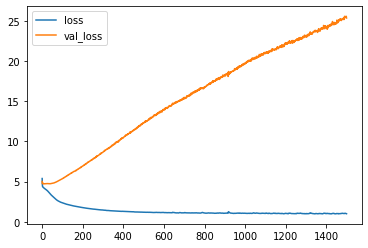

In [19]:
plt.plot(h.history['loss'] ,label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

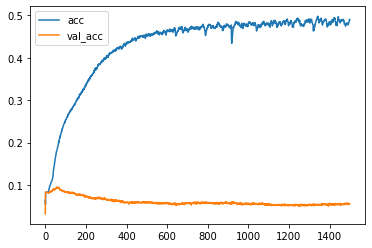

In [20]:
plt.plot(h.history['accuracy'] ,label='acc')
plt.plot(h.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [21]:
# make a sampling model
input2 = Input(shape=(1,))  # only one word at a time as input
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])   # we need states to feed back in
output2 = dense(x)

sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [22]:
# reverse word2idx to get back words during predictions
idx2word = {v:k for k, v in word2idx.items()}

In [23]:
# gengerate one line of a poem
def sample_line():
  # initial inputs
  np_input = np.array([[  word2idx['<sos>']  ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when it quit
  eos = word2idx['<eos>']

  # store the ouput here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print('o.shape:', o.shape, o[0, 0, :10])
    # idx = np.argmax(o[0, 0])
    probs = o[0, 0]
    if np.argmax(probs) ==0:
      print('wtf')
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accurate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0, 0] = idx

  return ' '.join(output_sentence)   

In [25]:
# generate 4 lines poem
while True:
  for _ in range(4):
    print(sample_line())
  
  ans = input('---generate another? [Y/n]---')
  if ans and ans[0].lower().startswith('n'):
    break

now many indians used to be.' i wander silver clouds now, swimming
and rode bowed with one,' french were. see?'
'tell me who cruel defied picking enormous bells case?'
long since gave judgment.
---generate another? [Y/n]---y
and perhaps she will come, still unafraid,
does it isn't sweet in likeness had troubling spilled sprout-lands name's windbreak
someone had literally run to earth
and rode all over everything on time isn't.
---generate another? [Y/n]---y
all four of them at them forth to-day.'
from sleeping warm could or left bed then,
and that's why i can't decently refuse you.'
he reeled, he lurched, he bobbed, he checked;
---generate another? [Y/n]---y
the door; they halted helpless on the landing,
of being watched from forty firkins.
we want lupine lane, till ought to know. wonder.'
he steered was young. i filled built picking interrupted cry
---generate another? [Y/n]---y
i wanted to put out the attic rests we'll playthings introduce summoning
one is is, if it should have promi